<a href="https://colab.research.google.com/github/kihongMin/MLDL/blob/master/bottle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2


In [26]:
!git clone "https://github.com/parrotProj/proj1.git"

Cloning into 'proj1'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 17137 (delta 47), reused 76 (delta 24), pack-reused 17027
Receiving objects: 100% (17137/17137), 245.19 MiB | 29.89 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Checking out files: 100% (17041/17041), done.


In [27]:
cd proj1

/content/proj1/proj1/proj1


In [0]:
import Resize


In [29]:
ls

base.ipynb   modifed_res.ipynb  Request.py  test/
bottle_2.h5  __pycache__/       Resize.py   train/


In [30]:
X_train,Y_train = Resize.train(160)

input_size :  160


In [0]:
X_test,X_id = Resize.test(160)

In [32]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)
print(X_train.shape,Y_train.shape)

(14034, 160, 160, 3) (14034, 6)


In [0]:
from keras import Input
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout
from keras.layers import Add, ZeroPadding2D, Flatten
'''
## 이미지 사이즈 너무 작아서 원래 인풋에서 7x7로 맥스풀링하던거 빼버림
## 대신에 3x3 layer 2개 붙여서  첫번째거에서는 stride=(1,1), padding='same'
##                          두번째거에서는 stride=(2,2), padding='same'
                            으로 5x5 conv로 다운사이징 해보자.
'''
def input_block(x):
    
    x = Convolution2D(32, (3,3), strides = (1,1),padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32, (3,3), strides = (1,1), padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    return x

In [0]:
import keras.layers

In [0]:
def bottle_neck(x,channels,d_increase=False):
    channel_1,channel_2,channel_3 = channels
    shortcut = x  
           
    if d_increase == True:
        x = MaxPooling2D((2,2))(x)
        #인풋 1x1 conV
        x = Convolution2D(channel_1,kernel_size=(1,1),strides=(1,1),padding="same",kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        #3x3 coV
        x = Convolution2D(channel_2,kernel_size=(3,3), padding = "same", kernel_initializer = 'he_normal')(x)        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        #얘가 너무 애매해서 케라스 github봤는데 제로 패딩안하고 그냥 conv 때려버림
        shortcut = Convolution2D(channel_3,kernel_size=(1,1),strides=(2,2),padding='valid',kernel_initializer='he_normal')(shortcut)
   
    else:
        x = Convolution2D(channel_1,kernel_size=(1,1),strides=(1,1),padding="same",kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Convolution2D(channel_2, kernel_size=(3,3), padding = "same", kernel_initializer = 'he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    #1x1 conv 차원 복원
    x = Convolution2D(channel_3, kernel_size=(1,1), padding = "valid", kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x,shortcut])
    x = Activation('relu')(x)
    return x

In [0]:
def block_group(x, channels, num_blocks):
    for i in range(num_blocks):
        if i==0 :
            x = bottle_neck(x,channels,True)            
        else:
            x = bottle_neck(x,channels,)    
    return x

In [0]:
def result(x, channels=64):
    input_data=x            #150 * 150 *3
    x = input_block(x)

    #원래 있던 3x3 maxpooling 뺌

    #channel은 bottleneck layer에서 채널 갯수. 이거 너무 줄인거 같음
    x = block_group(x, [16,16,64], 3)
    
    x = block_group(x, [32,32,128], 4)

    x = block_group(x, [64,64,256], 8)

    
    x = GlobalAveragePooling2D()(x)
    output_data = Dense(6,activation='softmax')(x)
    
    model = Model(input_data,output_data)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

In [0]:
inputs = Input(shape=(160,160,3),dtype='float32')
model = result(inputs)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 160, 160, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 160, 160, 32) 128         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 160, 160, 32) 0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

In [40]:
ls

base.ipynb   modifed_res.ipynb  Request.py  test/
bottle_2.h5  __pycache__/       Resize.py   train/


In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(shear_range=0.05, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True, zoom_range=0.2)
from sklearn.model_selection import train_test_split

X_train, X_Val, Y_train, Y_Val = train_test_split(X_train,Y_train, test_size=0.2)

In [43]:
train_generator = train_datagen.flow(X_train,Y_train,batch_size=128)
hist=model.fit_generator(train_generator,steps_per_epoch=len(X_train)/128,validation_data=(X_Val,Y_Val),
               validation_steps=32,epochs=90)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/90
88/87 [==============================] - 98s 1s/step - loss: 0.2658 - acc: 0.9070 - val_loss: 0.3389 - val_acc: 0.8828
Epoch 2/90
88/87 [==============================] - 78s 881ms/step - loss: 0.2417 - acc: 0.9124 - val_loss: 0.3008 - val_acc: 0.8921
Epoch 3/90
88/87 [==============================] - 79s 894ms/step - loss: 0.2243 - acc: 0.9202 - val_loss: 0.3802 - val_acc: 0.8742
Epoch 4/90
88/87 [==============================] - 79s 893ms/step - loss: 0.2254 - acc: 0.9207 - val_loss: 0.4160 - val_acc: 0.8557
Epoch 5/90
88/87 [==============================] - 80s 907ms/step - loss: 0.2216 - acc: 0.9207 - val_loss: 0.2910 - val_acc: 0.8988
Epoch 6/90
88/87 [==============================] - 80s 906ms/step - loss: 0.2136 - acc: 0.9209 - val_loss: 0.4260 - val_acc: 0.8753
Epoch 7/90
88/87 [==============================] - 80s 910ms/step - loss: 0.2022 - acc: 0.9276 - val_loss: 0

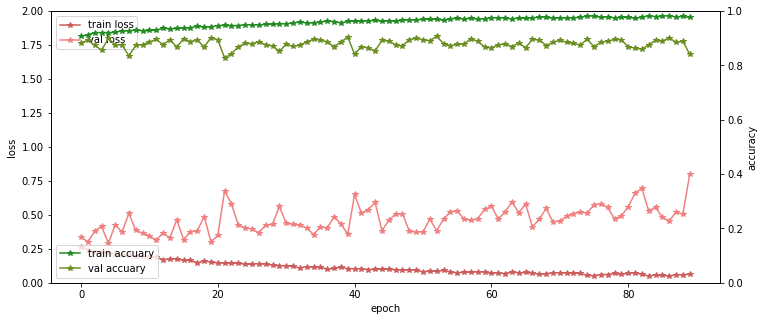

In [53]:
fig,loss_ax=plt.subplots(figsize=(12,5))
acc_ax=loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'indianred',marker='*',label='train loss')
loss_ax.plot(hist.history['val_loss'],'lightcoral',marker='*',label='val loss')


loss_ax.set_ylim([0, 2])


acc_ax.plot(hist.history['acc'],'forestgreen',marker='*',label='train accuary')
acc_ax.plot(hist.history['val_acc'],'olivedrab',marker='*',label='val accuary')
acc_ax.set_ylim([0, 1])


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
#모델 저장 및 가중치 저장

from google.colab import files
model.save_weights("model_weight.h5")
files.download("model_weight.h5")

model.save('bottle_model.h5')
files.download("bottle_model.h5")

In [0]:
result = model.predict(X_test,batch_size=128)
result = np.argmax(result,axis=1).reshape(-1,1)

output = pd.DataFrame(X_id)
output['pred_label'] = result
output.columns = ['id','pred_label']
output = output.set_index('id')

In [0]:
output.to_csv('prediction.csv')


files.download("prediction.csv")

In [49]:
output['count']=1
output.groupby('pred_label').sum()

,count
pred_label,
0,402
1,329
2,631
3,648
4,523
5,467
